In [1]:
# import self-written modules
from FeatEngg import ngramEnc,ctdEnc,gaacEnc
from mySVM.model import SVM
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import modules
import numpy as np

np.random.seed(7)

In [4]:
file = pickle.load(open('TE_ML_Data_pickle.p','rb'))

In [5]:
from helper import parseEnzymeFile,modified_split

In [6]:
enzyme_filename = 'Data/Enzyme_Dataset.txt'

X,y,enz_names = parseEnzymeFile(enzyme_filename)

In [7]:
test_idx,train_idx = modified_split(enz_names)

# Position-Model

In [8]:
from IndModels.models import PosModel

In [9]:
posModel = PosModel('TE_ML_Data_pickle.p',enz_names,X,y,train_idx,test_idx,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9629629629629629-----
-----Testing Accuracy:0.76-----


# NG only model

In [10]:
from IndModels.models import NGModel

ngModel = NGModel(enz_names,X,y,train_idx,test_idx,k=7,s=1,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9876543209876543-----
-----Testing Accuracy:0.76-----


# GAAC and NG model

In [11]:
from IndModels.models import GAACModel

gaacModel = GAACModel(enz_names,X,y,train_idx,test_idx,k=9,s=1,pca_components=40,verboseQ=True)

-----Initial Model Evaluation-----
-----Training Accuracy:0.9629629629629629-----
-----Testing Accuracy:0.76-----


# Majority Vote Classifier

In [12]:
from Ensemble.model import Ensemble

In [13]:
EModel = Ensemble([posModel.model,gaacModel.model,ngModel.model],
                  [posModel.Xtest,gaacModel.Xtest,ngModel.Xtest],y[test_idx])

In [14]:
EModel.acc

0.76

# Different random seeds

In [15]:
def multiprocess_func(randomseed):
    np.random.seed(randomseed)
    test_idx_i,train_idx_i = modified_split(enz_names)
    
    posModel_i = PosModel('TE_ML_Data_pickle.p',enz_names,X,y,train_idx_i,test_idx_i,randomseed=randomseed)
    ngModel_i = NGModel(enz_names,X,y,train_idx_i,test_idx_i,randomseed=randomseed)
    gaacModel_i = GAACModel(enz_names,X,y,train_idx_i,test_idx_i,randomseed=randomseed)
    
    EModel_i = Ensemble([posModel_i.model,gaacModel_i.model,ngModel_i.model],
                  [posModel_i.Xtest,gaacModel_i.Xtest,ngModel_i.Xtest],y[test_idx_i])
    
    return posModel_i.SVMobject.acc_test,ngModel_i.SVMobject.acc_test,gaacModel_i.SVMobject.acc_test,EModel_i.acc
    
    
    
    

In [16]:
import multiprocessing as mp
print(mp.cpu_count())
pool = mp.Pool(mp.cpu_count())

8


In [17]:
%%time
accs = list(pool.map(multiprocess_func,[i for i in range(10000)]))

CPU times: user 437 ms, sys: 364 ms, total: 801 ms
Wall time: 11min 11s


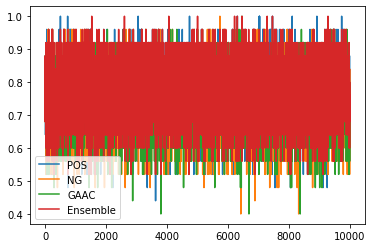

In [18]:
plt.plot(range(len(accs)),accs)
plt.legend(['POS','NG','GAAC','Ensemble'])

In [19]:
pos_preds = [a[0] for a in accs]
ng_preds = [a[1] for a in accs]
gaac_preds = [a[2] for a in accs]
ensemble_preds = [a[3] for a in accs]

In [20]:
min(pos_preds),np.mean(pos_preds)

(0.44, 0.7707360000000001)

In [21]:
min(ng_preds),np.mean(ng_preds)

(0.4, 0.7467520000000001)

In [22]:
min(gaac_preds),np.mean(gaac_preds)

(0.4, 0.7528600000000001)

In [23]:
min(ensemble_preds),np.mean(ensemble_preds)

(0.52, 0.776908)